In [2]:
from utils import load_data
import pandas as pd
import numpy as np
from scipy import sparse
import implicit
from sklearn.model_selection import train_test_split
from implicit import evaluation
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = load_data("./active1000")
df["time"] = df["time"].apply(
    lambda date: pd.Timestamp(date, unit="s", tz="Europe/Oslo")
)
df.drop(index=df[df.url == "http://adressa.no"].index, inplace=True)


In [4]:
def dataframe_to_user_item_matrix(df):
    df = df.drop_duplicates(subset=['userId', 'documentId'])
    df = df.sort_values(by=['userId', 'time'])

    n_users = df['userId'].nunique()
    n_items = df['documentId'].count()

    ratings = np.zeros((n_users, n_items))

    new_user = df['userId'].values[1:] != df['userId'].values[:-1]
    new_user = np.r_[True, new_user]

    df['uid'] = np.cumsum(new_user)
    item_ids = df['documentId'].unique().tolist()

    new_df = pd.DataFrame({'documentId': item_ids, 'tid': range(1, len(item_ids) + 1)})

    df = pd.merge(df, new_df, on='documentId', how='outer')
    user_id_document_df = df[['documentId', 'uid', 'userId']]
    df_ext = df[['uid', 'tid']]

    users_df = df["uid"].unique()
    user_indexes = set()

    for row in df_ext.itertuples():
        ratings[row[1] - 1, row[2] - 1] = 1.0

        if row[1] in users_df:
            user_indexes.add(row[1] - 1)

    print(f"Matrix created with {ratings.shape[0]} users and {ratings.shape[1]} items")
    return ratings, user_indexes, item_ids, user_id_document_df

user_item_data, user_indexes, item_ids, user_id_document_df = dataframe_to_user_item_matrix(df)

user_item_sparse_matrix = sparse.csr_matrix(user_item_data)
train_data, test_data = train_test_split(user_item_sparse_matrix, random_state=23, test_size=0.25)

Matrix created with 1000 users and 679355 items


In [8]:
'''
fit the model to the training data. factors is set to 50
'''
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(train_data)

/usr/local/lib/python3.9/site-packages/implicit/utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


In [5]:
'''
Create 50 recommendations for the first user. Outputs tuples of document_ids and the rating in the matrix.
'''
recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=50)
ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
print(list(zip(ids, list(recommendations[1]))))

[('aa6a5862cb2ae9fb8996f35a692192559b9083e1', 0.75877434), ('0a8c6555c75b8fd530be97356c8b62f6a6a4ad83', 0.7360717), ('cd625da5a4f18ba4912ce7c6a50340b364c2c7f1', 0.70930266), ('1ae48cc9bf00e7a94c6fb70e7beb74ee9b926998', 0.69789636), ('0bad5f842d38601fe714f625d46be941fb27f28c', 0.63664675), ('50c3b54c898d2c76681b4e4c02bad53b7a26b01b', 0.6297213), ('01e4d502d724e6206166c33c0ad50a456282124f', 0.61498), ('3580bacc6ca0f02842dedb898871778b4b264c9a', 0.595241), ('c5662a24bd7ed7754ca53afb4c5a1df6c60ab16b', 0.5882504), ('701d08c9626c66acf1bdb39454c3c3de4db5c8e1', 0.5851725), ('37bcd74a9f1aafaec15b4e01870c694636076147', 0.5828407), ('2febaa0c1a2bb66a3dda745c33ba3da7cc81a55b', 0.5666533), ('e9a8deeda6a04df6afb887619a3a1880250aed7a', 0.565036), ('60a5adfd53e73e44d1fdd9ed07c890879640b2e6', 0.564848), ('b9ad78ebb5acf15b97a2172aae104903e2a41afe', 0.5637803), ('6c2478c824124ec8060a58be8175b2bc6f4ce7b1', 0.5611747), ('55cb612b1b7f09e817909fb95156ef74f1711b70', 0.5585067), ('87497bca5ef49ff1ae7bbf31c6b82

In [9]:
'''
Function for evaluating precision for a certain user. takes in an array of ids that are recommended and a user index in the matrix.
'''
def precision(ids, user_index, max_recommendations = 50):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    true_positive = 0
    total = 0
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]

    docs_recommended_properly = []
    docs_not_recommended_properly = []

    for id in ids:
        try:
            if current_df[current_df.documentId == id].documentId.values[0] == id:
                docs_recommended_properly.append(id)
                true_positive += 1
        except:
            docs_not_recommended_properly.append(id)
        total += 1
    false_negative = current_df.head(max_recommendations).count().uid - true_positive
    return true_positive / (true_positive + false_negative)
precision(ids, 1, 50)
    

0.26

In [10]:
'''
Testing for different precision values on different users with recommendations set to 50
'''
precisions = []
for y in range(0, 100):
    recommendations = model.recommend(y, test_data[y], filter_already_liked_items=True, recalculate_user=True, N=50)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    precisions.append(precision(ids, y+1))
print('precisions: ' + str(precisions) + '\n')
print('average precision: ' + str(sum(precisions) / len(precisions)))


precisions: [0.26, 0.46, 0.16, 0.36, 0.44, 0.5, 0.3, 0.02, 0.42, 0.24, 0.58, 0.2, 0.54, 0.38, 0.42, 0.5, 0.34, 0.56, 0.46, 0.52, 0.68, 0.62, 0.34, 0.34, 0.16, 0.34, 0.26, 0.16, 0.24, 0.36, 0.5, 0.22, 0.24, 0.34, 0.32, 0.36, 0.24, 0.66, 0.4, 0.38, 0.24, 0.34, 0.52, 0.34, 0.32, 0.44, 0.24, 0.22, 0.6, 0.46, 0.46, 0.22, 0.72, 0.68, 0.5, 0.34, 0.6, 0.3, 0.24, 0.44, 0.42, 0.34, 0.4, 0.38, 0.28, 0.58, 0.58, 0.22, 0.36, 0.34, 0.52, 0.48, 0.4, 0.3, 0.54, 0.56, 0.52, 0.48, 0.56, 0.26, 0.12, 0.4, 0.42, 0.44, 0.34, 0.52, 0.36, 0.38, 0.16, 0.58, 0.6, 0.44, 0.52, 0.42, 0.42, 0.32, 0.32, 0.14, 0.54, 0.1]

average precision: 0.39100000000000007


<BarContainer object of 100 artists>

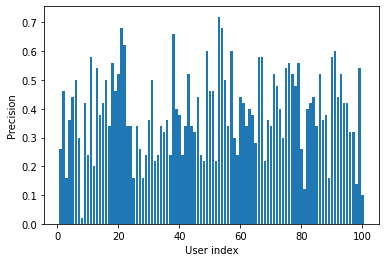

In [11]:
plt.ylabel('Precision')
plt.xlabel('User index')
plt.bar([x for x in range(1, 101)], height=precisions, data=precisions)

In [12]:
'''
Testing for different precision values on different number of recommendations for the same user
'''
precisions = []
for x in range(1, 101):
    recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=x)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    precisions.append(precision(ids, 1, x))
print('precisions: ' + str(precisions) + '\n')
print('average precision: ' + str(sum(precisions) / len(precisions)))


precisions: [1.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.2727272727272727, 0.3333333333333333, 0.38461538461538464, 0.42857142857142855, 0.4, 0.375, 0.4117647058823529, 0.4444444444444444, 0.42105263157894735, 0.4, 0.38095238095238093, 0.4090909090909091, 0.391304347826087, 0.375, 0.36, 0.34615384615384615, 0.3333333333333333, 0.35714285714285715, 0.3793103448275862, 0.4, 0.3870967741935484, 0.375, 0.36363636363636365, 0.35294117647058826, 0.34285714285714286, 0.3333333333333333, 0.32432432432432434, 0.3157894736842105, 0.3076923076923077, 0.3, 0.3170731707317073, 0.30952380952380953, 0.3023255813953488, 0.29545454545454547, 0.28888888888888886, 0.2826086956521739, 0.2765957446808511, 0.2708333333333333, 0.2653061224489796, 0.26, 0.2549019607843137, 0.25, 0.2641509433962264, 0.2777777777777778, 0.2727272727272727, 0.2857142857142857, 0.2807017543859649, 0.27586206896551724, 0.2711864406779661, 0.26666666666666666, 0.2

<BarContainer object of 100 artists>

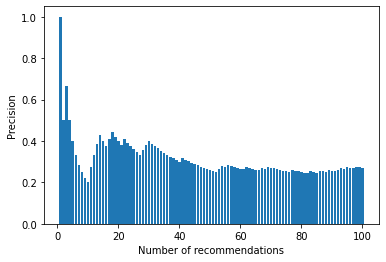

In [13]:
plt.ylabel('Precision')
plt.xlabel('Number of recommendations')
plt.bar([x for x in range(1, 101)], height=precisions, data=precisions)

In [14]:
def MRR(ids, user_index):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]
    ranks = []

    for index,id in enumerate(ids):
        try:
            if current_df[current_df.documentId == id].documentId.values[0] == id:
                ranks.append(1/index)
        except:
            ranks.append(0)
    return sum(ranks) / len(ranks)

In [16]:
'''
Testing for different MRR values on different users with recommendations set to 50
'''
MRRs = []
for y in range(0, 100):
    recommendations = model.recommend(y, test_data[y], filter_already_liked_items=True, recalculate_user=True, N=50)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    MRRs.append(MRR(ids, y+1))
print('MRRs: ' + str(MRRs) + '\n')
print('average MRR: ' + str(sum(MRRs) / len(MRRs)))

MRRs: [0.02304684319136652, 0.0462441798224247, 0.010350291365968857, 0.02570312092202848, 0.04809210174715431, 0.058285613705717845, 0.024893313892226935, 0.002857142857142857, 0.04885993515530943, 0.015552805307303057, 0.04142568311093639, 0.013821919879062738, 0.056287619143615394, 0.02362404458115481, 0.032178325712384284, 0.04643713493150721, 0.02264632428339522, 0.06128823899550774, 0.05315888948686372, 0.044854498546628256, 0.07004746608031656, 0.06767648375669397, 0.04367878217506987, 0.05149931550758477, 0.03681385056385056, 0.04393668578730978, 0.04134195848963938, 0.008343912085199632, 0.019614064668377427, 0.0417557429746654, 0.03997323408166717, 0.03047345200233688, 0.03086050954005261, 0.022490327084850402, 0.01269297466673154, 0.048163027252368235, 0.034403037601717534, 0.0679325527788741, 0.05408587510696758, 0.026557134205839515, 0.04442280772651616, 0.02705918016945838, 0.040955068329972144, 0.02372366550171775, 0.03488446641078219, 0.056526222942826256, 0.01232076717

<BarContainer object of 100 artists>

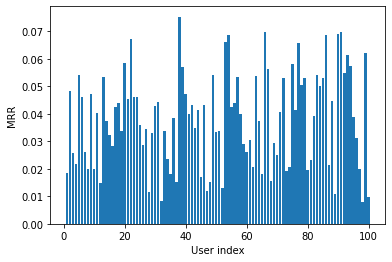

In [ ]:
plt.ylabel('MRR')
plt.xlabel('User index')
plt.bar([x for x in range(1, 101)], height=MRRs, data=MRRs)

In [18]:
def catalogue_coverage(user_index):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]
    documents = []

    recommendations = model.recommend(user_index, test_data[user_index], filter_already_liked_items=True, recalculate_user=True, N=50)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    for x in ids:
        documents.append(x)
    return list(set(documents))

cc = []
for x in range(1, user_id_document_df.nunique().uid -1):
    try:

        docs = catalogue_coverage(x)
        for y in docs:
            cc.append(y)
    except:
        break
cc = list(set(cc))

print(len(cc) / user_id_document_df.nunique().documentId)
        
    

0.05608533228470311
